# **Introduction**

Random Forest, Extreme Gradient Boosting (XGBoost), and Support Vector Machine (SVM) are three common machine learning models used in predictive analytics. Random Forest
is a bootstrap-aggregated tree-based model that builds ensemble models with weak-learning decision trees where each tree is created using the values of an independent 
set of random vectors derived from a fixed probability distribution. The Random Forest model is considered difficult to over-fit, easily interpretable, and very 
reliable.

Extreme Gradient Boosting is a model that creates a partition tree to make predictions on class-level outcomes using data subsets. New, subsequent partition trees are
applied to remaining batches of the dataset until residual error is minimized. The weight of each sample batch is adaptively changed after each round of boosting (new 
tree) such that the model focuses on building trees to correctly explain data contributing to incorrect classifications. This is repeated until optimal performance is 
obtained. However, XGBoost is prone to over-fitting.

The third model, Support Vector Machine, operates by searching for a hyperplane - a linear decision boundary - that provides the largest margin of separation between
classes in a dataset. SVM is therefore referred to as a maximal margin classifier. SVM maximizes the margin by minimizing the objective loss function. Because the
objective loss function is quadratic and the constraints are linear, SVM faces what is called a convex optimization problem that it solves using a Lagrange multiplier
method.

This study applies Random Forest, XGBoost, and an SVM to the same data set and the models are then compared in terms of processing speed, model accuracy, and model loss.
Speed is measured across a 2.1GHz processor with 32 cores. Because SVM is not parallelizable, core performance testing is fixed across only one processor core for the
SVM.

# **Methods**

## **Data**

The data provided for this case study is anonymized financial data, containing 131 features and a binary target.
Feature descriptions are were not provided and categories were recoded to non-descriptive letters.
The anonymity of the features and categories make preprocessing decisions difficult 
 as we cannot assess whether categorical features contain nominal or ordinal categories.
Because of the anonymity of the categorical features, 
 we chose to one-hot encode these features to avoid learning a spurious ordinal correlation on a nominal feature.
However, the feature `v22` contained over 18,000 categories.
It would have been impratical to one-hot encode this feature as it would have caused the feature space to grow intractably.
We decided to label encode this feature rather than one-hot encode it.


Since there are a large number of categorical features (19 in total) many of which contain a large number of categories (see table 1),
 the result of encoding was a relatively wide and sparse feature matrix.
It is known that very wide, sparse matrices typically do not lead to good models.
To account for the expanded feature space,
 we scaled the data (min-max scaling) and used Principle Components Analysis (PCA) to reduce the dimensionality of the feature matrix.
We determined the number of PCA components to use experimentally by fitting PCA with 100 components up to 400 components as shown in Fig. 1.
We selected 325 components since the varaince explained appeared to flatten after that point, 
 which explains about 98% of the variance of the higher dimensional feature space.
The Scikit-Learn implementation of PCA was used in this case study\footnotemark.

\footnotetext{https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html}

![PCA](./images/PCA_profile.png)




**Table 1. Categorical Features**

| Feature | Number of Categories | Encoding |
|----|---|---------|
| v3 | 3 | one-hot |
| v22 | 18210 | label-based |
| v24 | 5 | one-hot |
| v30 | 7 | one-hot |
| v31 | 3 | one-hot |
| v47 | 10 | one-hot |
| v52 | 12 | one-hot |
| v56 | 122 | one-hot |
| v66 | 3 | one-hot |
| v71 | 9 | one-hot |
| v74 | 3 | one-hot |
| v75 | 4 | one-hot |
| v79 | 18 | one-hot |
| v91 | 7 | one-hot |
| v107 | 7 | one-hot |
| v110 | 3 | one-hot |
| v112 | 22 | one-hot |
| v113 | 36 | one-hot |
| v125 | 90 | one-hot |

## **Models**

In this case study, we use Random Forest, XGBoost, and Support Vector Machines to model the data.
In the following sections, we descibe how these models work.

### **Random Forest**

A Random Forest is an emsemble model created from a collection of decision trees and bootstrapped aggregated (bagged) data (Breiman, 1996; James et al, 2013).
The following steps are used to create bagged trees:

  * bootstrap sample (repeated sampling with replacement) the dataset to create $B$ separate datasets.
  * fit a model $f^b(x)$ on each $B$ dataset.

Then the regression bagged model is given by

$$
f_{bag}(x) = \frac{1}{B} \sum_{b=1}^B f^b (x)
$$

In the context of classification, the *majority vote* of the classifiers is taken as the class prediction.
This is called a bagged decision tree model.
The aggregation of these high variance decision trees substantially reduces the overall model variance (James et al, 2013).
In general, a large number of decision tree should be used in the ensemble.
We treat the number of decision trees as a hyperparameter and tune it with cross-validation.

One additional tweak is added to a bagged decision tree to make it a random forest.
When building decision trees, at each split, the decision tree only considers a random subset of the available predictors (James et al, 2013).
This improves on the bagged model by decorrelating the individual trees used in the ensemble.
Two common methods for determing the number of predictors to consider in a split are the square root of the number of available features
 and log base-2 of the number of available features.
We treat the number of features the model considers at each split as a hyperparameter and tune it with cross-validation.
The SciKit-Learn (Pedregosa et al, 2011) implementation of random forest was used in this case study\footnotemark.


\footnotetext{https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html}

### **Extreme Gradient Boosting**

Extreme Gradient Boosting (XGBoost) is a gradient boosting method introduced by Chen & Guestrin in 2016.
Like bagging, gradient boosting is an ensemble technique that uses a set of weak learners (commonly decision trees) to produce better predictions.
However, in this ensemble, the individual models are stacked, meaning the output of one model is the input to another model.
Boosted models are built in a stage-wise fashion.
Unlike random forest and other bagging models, boosting is more susceptible to overfitting.
XGBoost is a more regularized model formulation, which gives more control over overfitting,
 leading to better performance over other boosted methods (Chen & Guestrin, 2016).
In this case study, we employ a decision tree based implementation of XGBoost.

### **Support Vector Machine**

The Support Vector Machine (SVM) is an algorithm from a class of maximal margin classifiers.
This type of model separates classes with a hyperplane that maximizes the margin between the decision boundry and
 the closest training examples (James et al, 2013).
In other words, the decision boundry is as far as possible from the training examples.
It turns out that only the data points within the margin or on the wrong side of the
 decision boundry affect the position of the chosen hyperplane (James et al, 2013).
These data points are called the *support vectors*.
The linear SVM can be represented as

$$
f \left( x \right) = \beta_0 + \sum_{i \in S}  \alpha_i \langle \vec{x_i}, \vec{x_i}\,' \rangle
$$

Where $S$ is the collection of indices of the support vectors,
 $\langle x_i, x_i' \rangle$ is the inner product between all the training examples in $S$,
 & $\alpha_i$ and $\beta_0$ are parameters to estimate.

In order to support non-linear decision boundaries, the SVM projects the data into a larger space using kernels (James et al, 2013).
The data may be separable in the high dimensional space.
Taking (2?), the inner product can be replaced with a generalization of the inner product


$$
f \left( x \right) = \beta_0 + \sum_{i \in S} K \left( \vec{x_i}, \vec{x_i}\,' \right)
$$

where $K$ is a kernel function.
Two commonly used kernel functions used in SVMs are the polynomial kernel of degree $d$

$$
K \left( x_i, x_i' \right) = \left( 1 + \sum_{j=1}^p x_{ij} x_{ij}' \right)^d
$$


and the radial kernel

$$
K \left( x_i, x_i' \right) = exp \left( -\gamma \sum_{j=1}^p \left( x_{ij} - x_{ij}' \right)^2 \right)
$$

where $\gamma$ is a positive constant and $p$ is the number of features.

Estimating the SVM in these high-dimensional spaces is considerably computationally expensive.
Thus, we should consider the complexity of the SVM when determining whether an SVM should be considered for the modeling problem.
In fact, in some cases, the feature space is so large that the computations become intractable (James et al, 2013).
The SVM implementation used in this case study, (Pedregosa et al, 2011; Chang & Lin, 2011), 
 is expected to have a complexity between $O\left(p \times n^2\right)$ and $O\left(p \times n^3\right)$, 
 where $p$ is the number of features and $n$ is the number of training examples\footnotemark.\footnotetext{https://scikit-learn.org/stable/modules/svm.html\#complexity}
The SciKit-Learn (Pedregosa et al, 2011) implementation of SVM\footnotemark,\footnotetext{https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html} 
which utilizes LIBSVM\footnotemark (Chang & Lin, 2011), was used in this case study.\footnotetext{https://www.csie.ntu.edu.tw/\textasciitilde cjlin/libsvm/}

 

## Model Validation

The models were validated on a 33% holdout dataset randomly sampled from the whole dataset.
The remaining 67% of the data was used for hyperparameter selection.
The steps for model validation are given below.
Additional details on hyperparameter tuning are given in the next section.

**Model Validation Procedure**

* Split data into 67% training and 33% test sets
* Search for hyperparameter using only the training data utilizing 5-fold internal cross-validation for random forest and XGBoost and 33% hold-out validation for SVM
* Estimate the error for each model with 5-fold internal cross-validation with the selected hyperparameters
* Test the performance of each model on the test set

In all cases, log loss was used as the model selection criterion, which is given below for the binary classification task.

$$
L_{log} \left( y, p \right) = - \left( y \log (p) + (1-y) \log (1- p) \right)
$$

where $y$ is the true label and $p$ is the probability estimate of the label being the positive label in a binary classification task ($p=Pr(y=1)$)

### **Hyperparameter Tuning**

Hyperparameters were selected with a randomized search.
We used a randomized search rather than an exhaustive search (sometimes called grid search) 
 because randomized searches have been shown to achieve similar results,
 but with significantly lower run times than exhaustive searches.
Unlike in an exhaustive search where all possible combinations of tuning parameters are validated,
 in a randomized search a number of search iterations are specified and
 a random set of parameters are validated on each iteration
The best parameters from the search are selected based on the log loss on a validation set for SVM and 
 mean log loss from 5-fold cross-validation for random forest and XGBoost.

We ran the random forest and XGBoost hyperparameter searches for 1,000 iterations.
We only ran the SVM hyperparameter search for 30 iterations due to the high run time of fitting the model.
We also 50% random down-sampled the SVM training dataset for the hyperparameter search to allow the search iterations
 to finish in a sufficient amount of time.
For reference, 1,000 tuning iterations of the random forest took ~6 hours,
 while 30 tuning iterations of the SVM took ~4.75 hours (See appendix A.2 and A.3 for more details).
The tuning parameters for each model used in the case study are shown in tables 2-4.

**Table 2. Random Forest Tuning Parameters**

| Parameter           | Search Range                    | Description |
|---------------------|:-------------------------------:|---------------------|
| `n_estimators`      | 10:150                          | Number of decision trees to use in the random forest |
| `criterion`         | `'gini'` or `'entropy'`         | The method for determining best split in decision trees |
| `max_depth`         | 10:100                          | The maximum depth decision trees can grow |
| `min_samples_split` | 2:100                           | The minimum number of samples required to make a split |
| `min_samples_leaf`  | 2:100                           | The minimum number of sample required to make a leaf node |
| `max_features`      | One of `'auto', 'sqrt', 'log2'` | The maximum number of features considered when making a split in a tree |

**Table 3. XGBoost Tuning Parameters**

| Parameter           | Search Range                    | Description |
|---------------------|:-------------------------------:|---------------------|
| `eta`               | 0.01:1                          | Effectively a learning rate |
| `gamma`             | 0.001:10\*           | Complexity |
| `max_depth`         | 1:11 | The maximum depth decision trees can grow |
| `colsample_bytree`  | 0.3:1 | Percentage of random features at the tree level|
| `colsample_bylevel` | 0.3:1 | Percentage of random features at the levels within the trees|
| `colsample_bynode`  | 0.3:1 | Percentage of random features at node level within the trees|
| `sumsample`         | 0.1:1 | Bagging |
| `lambda`            | 0.001:10\* | L2 regularization term on weights |
| `alpha`             | 0.001:10\* | L1 regularization term on weights |

\*Values of `gamma`, `lambda`, and `alpha` were sampled from the given distrubtion on a log scale.

**Table 4. SVM Tuning Parameters**

| Parameter | Search Range                                | Description |
|-----------|:-------------------------------------------:|---------------------|
| `C`       | 0.001:10\*                                  | The regularization strength |
| `kernel`  | One of `'linear', 'poly', 'rbf', 'sigmoid'` | The SVM kernel |
| `gamma`   | `'scale'`or `'auto'`                    | The kernel coefficient setting for `'poly', 'rbf',` and `'sigmoid'` |

\*Values of `C` were sampled from the given distrubtion on a log scale.

\newpage

# **Results**

## **Hyperparameters**


The hyperparameters selected by randomized search with 5-fold CV for random forest and XGBoost and hold-out validation for SVM are shown in tables 5-6.

**Table 5. Tuned Random Forest Hyperparameters**

**Table 6. Tuned XGBoost HyperParameters**

**Table 7. Tuned SVM HyperParameters**

\newpage

## **Validation Results**

The perfomance of cross-validation or hold-out validation of the models trained with the selected hyperparameters are shown in table 8.
The performance of the models with the selected hyperparameters are shown in table 9.


**Table 8. Cross-Validation/Holdout-Validation Performance**

**Table 9. Test Set Performance**

## **Complexity and Scaling**

As mentioned previously, we expect a complexity between $O \left(n^2 \right)$ and $O \left(n^3 \right)$ 
 from the implemetation of the SVM used in this case study.
We fit an SVM on subsets of the data with the following sizes: 1,000, 2,000, 5,000, 7,000, 10,000.
The fit times for the SVM is plotted vs the number or records in Fig. 2.
A quadratic fit is overlayed on the plot of the SVM observations in Fig. 2.
The quadratic appears to be reasonable for these dataset sizes, confirming our expectation of the SVM complexity.

For comparison, we also recorded the fit times for a random forest over the dataset sizes.
The complexity of decision trees is approximately 
$O \left(n \times log \left( n \right) \right)$\footnotemark\footnotetext{https://scikit-learn.org/stable/modules/tree.html\#complexity}
 for a fixed number of features.
Since a random forest is built from a collection of decision trees, 
 the complexity of a random forest should be approximately a multiple
 of the decision tree complexity.
While the SVM has lower fit times for the smaller datasets (less than 7000 records),
 the Random Forest appears to exhibit a linear relationship between the number of records and
 fit time.
We also overlayed a linear fit on the plot of the Random Forest observations in Fig. 2.
The linear fit appears to be reasonable for these dataset sizes.
**Note**: The following benchmarks were performed with a Xeon E5-2695v4 (2.1 GHz) 
CPU\footnotemark\footnotetext{https://ark.intel.com/content/www/us/en/ark/products/91316/intel-xeon-processor-e5-2695-v4-45m-cache-2-10-ghz.html}.

 

![RF_and_SVM_with_fits](./images/RF_SVM_Fits_Small.png)

The fit times with fits for SVM and Random Forest extended up to 70,000 records 
 (the approximate size of the training data)
 are shown in Fig. 3.
This figure shows how the extent to which the training times of the SVM and Random Forest diverge as the dataset increases.

![RF_and_SVM_extended](./images/RF_SVM_Fits.png)

In regards to computational complexity, parallelization is also a factor that should be considered since most modern processors contain multiple cores.
If a model can be distributed over several processor cores, 
 the training time could be significantly reduced depending on the scale of hardware available.
The implementations of Random Forest and XGBoost used in this case study could be distributed on multiple cores, 
 while the implementation of the SVM could not be distributed.
The effect of distributing training of a Random Forest is shown in Fig. 4.
The addition of just a few cores significantly reduces the time to train the Random Forest.
In this example, 


![RF_Parallel](./images/RF_profile.png)

# **Conclusion**

The results of this study confirm that when using a 2.1GHz processor with up to 32 cores, the boostrap-aggregated Random Forest model outperforms both Support Vector Machine and XGBoost on this data set, in terms of processing speed. Support Vector Machine proved faster than Random Forest and XGBoost for up to 7,000 observations. However, once applied to more than 7,000 observations or more than a single core, both Random Forest and XGBoost are faster than Support Vector Machine. Additionally, Random Forest and XGBoost are parallelizable and therefore can be split across multiple machines, if needed, which is a major drawback for Support Vector Machine.

In terms of accuracy and loss, the results of applying the three models to this data set show Random Forest outperforming both Support Vector Machine and XGBoost. Random Forest and Support Vector Machine appeared with similary accuracy and loss whereas those metrics for XGBoost were noticeably lower in performance. Notably, XGBoost responded the most to hyperparamater tuning than both Random Forest and Support Vector Machine. Upon additional feature engineering, we expect XGBoost and Random Forest to continue improving at a higher rate than Support Vector Machine based on the results of hyperparameter optimization.

Overall, this study concludes that on similar, large and diverse data sets, the Random Forest is likely to be the optimal model compared to XGBoost and Support Vector Machine based on its computation time, accuracy, and loss metrics.

# **Future Work**

We expect there would be fruitful work in feature selection and feature engineering on this dataset.
The feature work performed in this case study was minimal as it was not the aim of the study.

## **Dimensionality Reduction**

In this case study, we primarily used one-hot encodings to preprocess the categories.
Becasue of the number categorical variables and the cardinality of the categorical variables
 one-hot encoding these features expands the feature spase of the dataset significantly.
The feature space was reduced using PCA, but 325 features remained after the reduction,
 which is still more than double the initial size of the feature space.
Since the complexity of algorithms for SVMs and decision trees scales linearly with the data feature space, 
 improved dimensionality reduction would like be an important factor for reducing model training times.


## **Feature Ranking**

Many modeling methods such as random forest contain inherent methods for ranking importance of features.
These feature importance measures could potentially be used to rank features and suggest features for elimiation
 or reduction.


# **References**

Breiman, L. (1996). Bagging Predictors. Machine Learning, 24, 123-140.

Chang, C.C., & Lin, C.J. (2011). LIBSVM: A library for support vector machines. *ACM Transactions on Intelligent Systems and Technology*, 2, 27:1–27:27.

Chen, T. & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System.. In B. Krishnapuram, M. Shah, A. J. Smola, C. Aggarwal, D. Shen & R. Rastogi (eds.), KDD (p./pp. 785-794), : ACM. ISBN: 978-1-4503-4232-2

James, G., Witten, D., Hastie, T., Tibshirani, R. (2013). An Introduction to Statistical Learning: with Applications in R . Springer.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., . . . Duchesnay, É. (2011). Scikit-learn: Machine learning in python. *Journal of Machine Learning Research*, Retrieved from https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf

# Code

In [2]:
import time
import pprint
import os

import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA 
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    make_scorer)
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV, 
    cross_validate)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

log_loss_scorer = make_scorer(log_loss, greater_is_better=False)
accuracy_scorer = make_scorer(accuracy_score)

random_state = np.random.RandomState(42)

## Data Formatting

In [2]:
# get the data
data = pd.read_csv('./data/case_8.csv')
# put the target in another variable
target = data.target
# drop off ID and target
data = data.drop(['ID', 'target'], axis=1)

In [3]:
# count the number of members in each categorigal feature
obj_columns = list(data.select_dtypes(include='object'))

categories = list()
for col in obj_columns:
    categories.append(
        len(np.unique(data[col]))
    )

for col, cat in zip(obj_columns, categories):
    print(col, cat)

v3 3
v22 18210
v24 5
v30 7
v31 3
v47 10
v52 12
v56 122
v66 3
v71 9
v74 3
v75 4
v79 18
v91 7
v107 7
v110 3
v112 22
v113 36
v125 90


In [4]:
# convert cats to one-hots
obj_columns = list(data.drop(['v22'], axis=1).select_dtypes(include='object'))
onehots = pd.get_dummies(data[obj_columns])

# label encode v22
data['v22'] = LabelEncoder().fit_transform(data['v22'])

In [5]:
encoded = pd.concat([data.drop(obj_columns, axis=1), onehots], axis = 1)
ss = StandardScaler()

In [6]:
# calculate variance explained over n_components
# to est the number needed
var_explained = list()
component_sizes = [i for i in range(100, 400 + 1, 25)]
ss = StandardScaler()
for n_comp in component_sizes:
    pca = PCA(n_components = n_comp)
    pca.fit(ss.fit_transform(encoded))
    var_explained.append(np.sum(pca.explained_variance_ratio_))
    

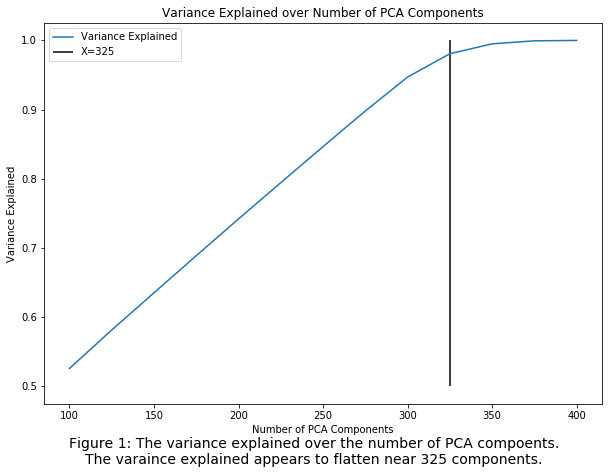

In [7]:
plt.figure(figsize=(10,7))
plt.plot(component_sizes, var_explained, label = 'Variance Explained')
plt.vlines(325, 0.5, 1, label = 'X=325')
plt.ylabel('Variance Explained')
plt.xlabel('Number of PCA Components')
plt.title('Variance Explained over Number of PCA Components');
caption = 'Figure 1: The variance explained over the number of PCA compoents.\n\
The varaince explained appears to flatten near 325 components.'
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=14);
#plt.savefig('./images/PCA_profile.png')
plt.legend();

In [7]:
# fit and transform data with PCA
pca = PCA(n_components = 325)
encoded_pca = pca.fit_transform(ss.fit_transform(encoded))
np.sum(pca.explained_variance_ratio_)

0.9807605595212088

In [8]:
X_train, X_test, y_train, y_test = train_test_split(encoded_pca,
                                                    target,
                                                    test_size=0.33,
                                                    random_state=random_state)

## Random Forest

```python
# random forest

rf_clf = RandomForestClassifier(random_state=random_state)
rf_params = {
    'n_estimators': np.linspace(10, 150, dtype='int'),
    'criterion':['gini', 'entropy'],
    'max_depth': np.linspace(10, 100, dtype='int'),
    'min_samples_split': np.linspace(2, 100, 50, dtype='int'),
    'min_samples_leaf': np.linspace(2, 100, 50, dtype='int'),
    'max_features': ['auto', 'sqrt', 'log2']
}

search_iters = 100

rf_RSCV_start_time = time.time()
# setup search
rf_RSCV = RandomizedSearchCV(rf_clf, rf_params, scoring=log_loss_scorer,
                             n_iter=search_iters, random_state=random_state,
                             n_jobs=6)
# seach
rf_RSCV.fit(X_train, y_train)

rf_RSCV_end_time = time.time()
duration = rf_RSCV_end_time-rf_RSCV_start_time

print(f'Randomized CV search done. {search_iters} iterations took \
{int(duration // 3600):02d}::{int((duration % 3600) // 60):02d}::{int((duration % 3600) % 60):02d}')
```

```
Randomized CV search done. 1000 iterations took 04::58::14
```

```python
# print the best parameters chosen by CV
pprint.pprint(rf_RSCV.best_params_)
```

```
{'criterion': 'entropy',
 'max_depth': 41,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 98}
```

```python
# get CV results with best parameters
rf_clf.set_params(**rf_RSCV.best_params_)
rf_cv = cross_validate(rf_clf, X_train, y_train, n_jobs=6 
                       scoring={
                           'log_loss':log_loss_scorer,
                           'accuracy':accuracy_scorer
                       })
```

```python
print('RF 5-fold Validation Performance')
# note test_log_loss is negated due to how scorers work 
# in parameter searches in sklearn
print('Mean Log Loss\t{}'.format(np.mean(-rf_cv['test_log_loss'])))
print('Mean Accuracy\t{}'.format(np.mean(rf_cv['test_accuracy'])))
```

```
RF 5-fold Validation Performance
Mean Log Loss	8.097484669489114
Mean Accuracy	0.7655591096024545
```

```python
# get performance on test set
rf_clf.fit(X_train, y_train)
rf_y_test_pred = rf_clf.predict(X_test)

print('RF Test Set Performance')
print('Test Log Loss\t{}'.format(log_loss(rf_y_test_pred, y_test)))
print('Test Accuracy\t{}'.format(accuracy_score(rf_y_test_pred, y_test)))
```

```
RF Test Set Performance
Test Log Loss	8.077607041354009
Test Accuracy	0.7661294597890049
```

```python
# do some fit times for comparison with the RF
cpuCount = os.cpu_count()
print(f'There are {cpuCount} cores available.\n')
cores, sizes, times = list(), list(), list()
for n_cores in [1, 2, 3, 4, 5, 6, 9, 12, 15, 18, 24, 32]:
    for size in [1000, 2000, 5000, 7000, 10000,
                 15000, 20000, 25000, 30000, 45000, 60000, 70000]:
        rf_clf = RandomForestClassifier(random_state=random_state)
        #rf_clf.set_params(**best_params)
        rf_clf.set_params(**{'n_jobs': n_cores})
        sample = random_state.choice(np.arange(len(X_train)), size=size, replace=False)
        X_train_sub = X_train[sample, :]
        y_train_sub = y_train.iloc[sample]
        start_time = time.time()
        rf_clf.fit(X_train_sub, y_train_sub)
        end_time = time.time()
        duration = end_time - start_time
        print(f'RF fit on {size} records with {n_cores} took {duration}')
        cores.append(n_cores)
        sizes.append(size)
        times.append(duration)
```

```python
time_data = pd.DataFrame({
    'cores':cores,
    'sizes':sizes,
    'times':times})

# save the profile for later
time_data.to_csv('./data/RF_profiling.csv')
```

```
RF fit on 1000 records with 1 took 1.7938592433929443
RF fit on 2000 records with 1 took 4.551750183105469
RF fit on 5000 records with 1 took 13.484930515289307
RF fit on 7000 records with 1 took 19.926262855529785
RF fit on 10000 records with 1 took 29.851879835128784
RF fit on 15000 records with 1 took 48.56377577781677
RF fit on 20000 records with 1 took 69.73959302902222
RF fit on 25000 records with 1 took 86.8936197757721
RF fit on 30000 records with 1 took 109.04715633392334
RF fit on 45000 records with 1 took 171.38095211982727
RF fit on 60000 records with 1 took 239.53111362457275
RF fit on 70000 records with 1 took 283.2488453388214
RF fit on 1000 records with 2 took 1.0079431533813477
RF fit on 2000 records with 2 took 2.337416648864746
RF fit on 5000 records with 2 took 6.612889051437378
RF fit on 7000 records with 2 took 10.412444114685059
RF fit on 10000 records with 2 took 15.667192697525024
RF fit on 15000 records with 2 took 24.670193195343018
RF fit on 20000 records with 2 took 34.1747260093689
RF fit on 25000 records with 2 took 44.50364875793457
RF fit on 30000 records with 2 took 55.049652338027954
RF fit on 45000 records with 2 took 86.46168375015259
RF fit on 60000 records with 2 took 121.4938645362854
RF fit on 70000 records with 2 took 145.65200638771057
RF fit on 1000 records with 3 took 0.7138559818267822
RF fit on 2000 records with 3 took 1.562631368637085
RF fit on 5000 records with 3 took 4.590010404586792
RF fit on 7000 records with 3 took 6.938733100891113
RF fit on 10000 records with 3 took 10.22381043434143
RF fit on 15000 records with 3 took 17.723241806030273
RF fit on 20000 records with 3 took 24.305588960647583
RF fit on 25000 records with 3 took 30.654436349868774
RF fit on 30000 records with 3 took 37.52491474151611
RF fit on 45000 records with 3 took 60.25975942611694
RF fit on 60000 records with 3 took 83.2231342792511
RF fit on 70000 records with 3 took 98.38715028762817
RF fit on 1000 records with 4 took 0.5686631202697754
RF fit on 2000 records with 4 took 1.2984797954559326
RF fit on 5000 records with 4 took 3.62783145904541
RF fit on 7000 records with 4 took 5.312462091445923
RF fit on 10000 records with 4 took 8.256167888641357
RF fit on 15000 records with 4 took 13.107549667358398
RF fit on 20000 records with 4 took 18.09895086288452
RF fit on 25000 records with 4 took 23.987131357192993
RF fit on 30000 records with 4 took 28.783096313476562
RF fit on 45000 records with 4 took 46.00150728225708
RF fit on 60000 records with 4 took 65.57577538490295
RF fit on 70000 records with 4 took 75.82016110420227
RF fit on 1000 records with 5 took 0.4985780715942383
RF fit on 2000 records with 5 took 1.1504936218261719
RF fit on 5000 records with 5 took 3.138023614883423
RF fit on 7000 records with 5 took 4.476421594619751
RF fit on 10000 records with 5 took 6.607249736785889
RF fit on 15000 records with 5 took 10.45406436920166
RF fit on 20000 records with 5 took 15.829338788986206
RF fit on 25000 records with 5 took 20.526665210723877
RF fit on 30000 records with 5 took 23.957329511642456
RF fit on 45000 records with 5 took 38.359968185424805
RF fit on 60000 records with 5 took 52.635693311691284
RF fit on 70000 records with 5 took 66.05289030075073
RF fit on 1000 records with 6 took 0.4408392906188965
RF fit on 2000 records with 6 took 0.870203971862793
RF fit on 5000 records with 6 took 2.5214035511016846
RF fit on 7000 records with 6 took 3.8897624015808105
RF fit on 10000 records with 6 took 5.544603109359741
RF fit on 15000 records with 6 took 9.014483213424683
RF fit on 20000 records with 6 took 12.350444316864014
RF fit on 25000 records with 6 took 16.171870470046997
RF fit on 30000 records with 6 took 20.213287115097046
RF fit on 45000 records with 6 took 32.16866660118103
RF fit on 60000 records with 6 took 44.39087200164795
RF fit on 70000 records with 6 took 53.690847635269165
RF fit on 1000 records with 9 took 0.34802699089050293
RF fit on 2000 records with 9 took 0.7169685363769531
RF fit on 5000 records with 9 took 1.8683745861053467
RF fit on 7000 records with 9 took 2.6876518726348877
RF fit on 10000 records with 9 took 4.059927940368652
RF fit on 15000 records with 9 took 6.369987964630127
RF fit on 20000 records with 9 took 9.024513721466064
RF fit on 25000 records with 9 took 11.60956335067749
RF fit on 30000 records with 9 took 14.308605909347534
RF fit on 45000 records with 9 took 22.506808519363403
RF fit on 60000 records with 9 took 30.44385600090027
RF fit on 70000 records with 9 took 36.87260866165161
RF fit on 1000 records with 12 took 0.29494190216064453
RF fit on 2000 records with 12 took 0.5495619773864746
RF fit on 5000 records with 12 took 1.4914238452911377
RF fit on 7000 records with 12 took 2.2223565578460693
RF fit on 10000 records with 12 took 3.33021879196167
RF fit on 15000 records with 12 took 5.2223851680755615
RF fit on 20000 records with 12 took 7.1956093311309814
RF fit on 25000 records with 12 took 9.286618947982788
RF fit on 30000 records with 12 took 11.621920108795166
RF fit on 45000 records with 12 took 18.222316026687622
RF fit on 60000 records with 12 took 24.9249370098114
RF fit on 70000 records with 12 took 32.06112718582153
RF fit on 1000 records with 15 took 0.2799348831176758
RF fit on 2000 records with 15 took 0.4700953960418701
RF fit on 5000 records with 15 took 1.2451682090759277
RF fit on 7000 records with 15 took 1.7748494148254395
RF fit on 10000 records with 15 took 2.726682186126709
RF fit on 15000 records with 15 took 4.415498971939087
RF fit on 20000 records with 15 took 6.11004638671875
RF fit on 25000 records with 15 took 7.9151623249053955
RF fit on 30000 records with 15 took 9.694298028945923
RF fit on 45000 records with 15 took 15.316873550415039
RF fit on 60000 records with 15 took 21.906368494033813
RF fit on 70000 records with 15 took 26.313856840133667
RF fit on 1000 records with 18 took 0.25330257415771484
RF fit on 2000 records with 18 took 0.42156529426574707
RF fit on 5000 records with 18 took 1.0853703022003174
RF fit on 7000 records with 18 took 1.5614571571350098
RF fit on 10000 records with 18 took 2.3143110275268555
RF fit on 15000 records with 18 took 3.7090070247650146
RF fit on 20000 records with 18 took 5.269637823104858
RF fit on 25000 records with 18 took 6.762773513793945
RF fit on 30000 records with 18 took 8.49036693572998
RF fit on 45000 records with 18 took 13.021652221679688
RF fit on 60000 records with 18 took 18.151607275009155
RF fit on 70000 records with 18 took 21.519808292388916
RF fit on 1000 records with 24 took 0.24412107467651367
RF fit on 2000 records with 24 took 0.34689998626708984
RF fit on 5000 records with 24 took 0.9163515567779541
RF fit on 7000 records with 24 took 1.30739426612854
RF fit on 10000 records with 24 took 2.000126600265503
RF fit on 15000 records with 24 took 3.1019132137298584
RF fit on 20000 records with 24 took 4.383680582046509
RF fit on 25000 records with 24 took 5.392063856124878
RF fit on 30000 records with 24 took 6.780743598937988
RF fit on 45000 records with 24 took 10.465697050094604
RF fit on 60000 records with 24 took 14.940185070037842
RF fit on 70000 records with 24 took 17.41328191757202
RF fit on 1000 records with 32 took 0.23822546005249023
RF fit on 2000 records with 32 took 0.34743165969848633
RF fit on 5000 records with 32 took 0.7463643550872803
RF fit on 7000 records with 32 took 1.0852611064910889
RF fit on 10000 records with 32 took 1.5256133079528809
RF fit on 15000 records with 32 took 2.48722767829895
RF fit on 20000 records with 32 took 3.506418228149414
RF fit on 25000 records with 32 took 4.473333120346069
RF fit on 30000 records with 32 took 5.3561577796936035
RF fit on 45000 records with 32 took 8.71953010559082
RF fit on 60000 records with 32 took 11.787147283554077
RF fit on 70000 records with 32 took 14.299548149108887
```

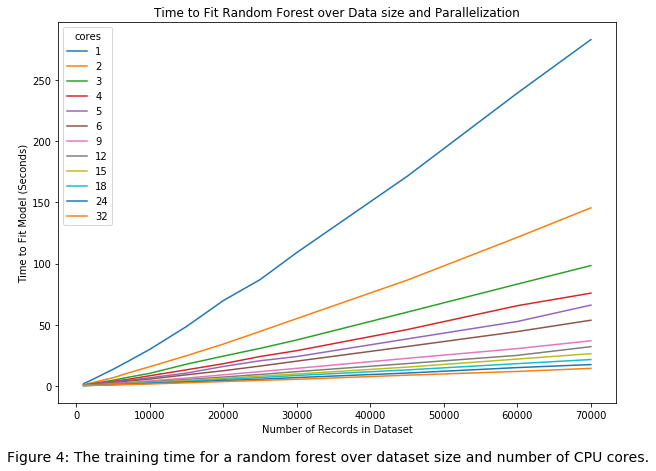

In [9]:
time_data = pd.read_csv('./data/RF_profiling.csv')
df = time_data.pivot(index='sizes', columns='cores', values='times')

df.plot(figsize = (10,7))
plt.ylabel('Time to Fit Model (Seconds)')
plt.xlabel('Number of Records in Dataset')
plt.title('Time to Fit Random Forest over Data size and Parallelization');
caption = 'Figure 4: The training time for a random forest over dataset size and number of CPU cores.'
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=14);
plt.savefig('./images/RF_profile.png')

We then re-ran this on 8 cores using a 3.60GHz processor. 

```
There are 8 cores available.

RF fit on 1000 records with 1 took 0.7325282096862793
RF fit on 2000 records with 1 took 1.5340876579284668
RF fit on 5000 records with 1 took 4.334455490112305
RF fit on 7000 records with 1 took 6.57518458366394
RF fit on 10000 records with 1 took 10.218626737594604
RF fit on 15000 records with 1 took 16.821902751922607
RF fit on 20000 records with 1 took 24.0005464553833
RF fit on 25000 records with 1 took 32.05216073989868
RF fit on 30000 records with 1 took 38.171722173690796
RF fit on 45000 records with 1 took 60.81484055519104
RF fit on 60000 records with 1 took 85.50019979476929
RF fit on 70000 records with 1 took 100.68615770339966
RF fit on 1000 records with 2 took 0.43102145195007324
RF fit on 2000 records with 2 took 0.8261690139770508
RF fit on 5000 records with 2 took 2.358612298965454
RF fit on 7000 records with 2 took 3.431283712387085
RF fit on 10000 records with 2 took 5.135213613510132
RF fit on 15000 records with 2 took 8.441932916641235
RF fit on 20000 records with 2 took 11.850683212280273
RF fit on 25000 records with 2 took 15.157580852508545
RF fit on 30000 records with 2 took 19.066733837127686
RF fit on 45000 records with 2 took 30.291439294815063
RF fit on 60000 records with 2 took 44.22365379333496
RF fit on 70000 records with 2 took 53.34113597869873
RF fit on 1000 records with 3 took 0.32468509674072266
RF fit on 2000 records with 3 took 0.6573364734649658
RF fit on 5000 records with 3 took 1.6530845165252686
RF fit on 7000 records with 3 took 2.3515520095825195
RF fit on 10000 records with 3 took 3.6334645748138428
RF fit on 15000 records with 3 took 5.9388628005981445
RF fit on 20000 records with 3 took 8.34729290008545
RF fit on 25000 records with 3 took 10.852374792098999
RF fit on 30000 records with 3 took 13.461628437042236
RF fit on 45000 records with 3 took 21.97763967514038
RF fit on 60000 records with 3 took 29.99700427055359
RF fit on 70000 records with 3 took 36.41062116622925
RF fit on 1000 records with 4 took 0.2249605655670166
RF fit on 2000 records with 4 took 0.5253725051879883
RF fit on 5000 records with 4 took 1.2277600765228271
RF fit on 7000 records with 4 took 1.8287036418914795
RF fit on 10000 records with 4 took 2.8327317237854004
RF fit on 15000 records with 4 took 4.43706750869751
RF fit on 20000 records with 4 took 6.243618965148926
RF fit on 25000 records with 4 took 8.146894931793213
RF fit on 30000 records with 4 took 9.953494310379028
RF fit on 45000 records with 4 took 16.069380283355713
RF fit on 60000 records with 4 took 22.886408805847168
RF fit on 70000 records with 4 took 28.000638484954834
RF fit on 1000 records with 5 took 0.22353076934814453
RF fit on 2000 records with 5 took 0.4252810478210449
RF fit on 5000 records with 5 took 1.0440244674682617
RF fit on 7000 records with 5 took 1.5292558670043945
RF fit on 10000 records with 5 took 2.2301242351531982
RF fit on 15000 records with 5 took 3.5417864322662354
RF fit on 20000 records with 5 took 5.0404651165008545
RF fit on 25000 records with 5 took 6.55643367767334
RF fit on 30000 records with 5 took 8.149805545806885
RF fit on 45000 records with 5 took 12.963913917541504
RF fit on 60000 records with 5 took 18.58751368522644
RF fit on 70000 records with 5 took 22.390990734100342
RF fit on 1000 records with 6 took 0.22570466995239258
RF fit on 2000 records with 6 took 0.340789794921875
RF fit on 5000 records with 6 took 0.9280984401702881
RF fit on 7000 records with 6 took 1.3614921569824219
RF fit on 10000 records with 6 took 1.8418936729431152
RF fit on 15000 records with 6 took 3.0342633724212646
RF fit on 20000 records with 6 took 4.35231876373291
RF fit on 25000 records with 6 took 5.452936172485352
RF fit on 30000 records with 6 took 6.949592113494873
RF fit on 45000 records with 6 took 11.072781324386597
RF fit on 60000 records with 6 took 15.682738542556763
RF fit on 70000 records with 6 took 18.785224437713623
RF fit on 1000 records with 7 took 0.2249281406402588
RF fit on 2000 records with 7 took 0.35457944869995117
RF fit on 5000 records with 7 took 0.8352601528167725
RF fit on 7000 records with 7 took 1.1424071788787842
RF fit on 10000 records with 7 took 1.6311793327331543
RF fit on 15000 records with 7 took 2.744840621948242
RF fit on 20000 records with 7 took 3.7560818195343018
RF fit on 25000 records with 7 took 4.856971740722656
RF fit on 30000 records with 7 took 6.061952352523804
RF fit on 45000 records with 7 took 9.769068241119385
RF fit on 60000 records with 7 took 13.887884140014648
RF fit on 70000 records with 7 took 16.688308477401733
RF fit on 1000 records with 8 took 0.22538065910339355
RF fit on 2000 records with 8 took 0.3279874324798584
RF fit on 5000 records with 8 took 0.7303600311279297
RF fit on 7000 records with 8 took 1.1104011535644531
RF fit on 10000 records with 8 took 1.6573877334594727
RF fit on 15000 records with 8 took 2.4776809215545654
RF fit on 20000 records with 8 took 3.344752311706543
RF fit on 25000 records with 8 took 4.340478420257568
RF fit on 30000 records with 8 took 5.443612575531006
RF fit on 45000 records with 8 took 8.859633684158325
RF fit on 60000 records with 8 took 12.575875043869019
RF fit on 70000 records with 8 took 15.685734987258911
```

In [ ]:
time_data = pd.read_csv('./data/RF_profiling.csv')
df = time_data.pivot(index='sizes', columns='cores', values='times')

df.plot(figsize = (10,7))
plt.ylabel('Time to Fit Model (Seconds)')
plt.xlabel('Number of Records in Dataset')
plt.title('Time to Fit Random Forest over Data size and Parallelization');
caption = 'Figure X: The training time for a random forest over dataset size and number of CPU cores.'
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=14);
plt.savefig('./images/RF_profile.png')

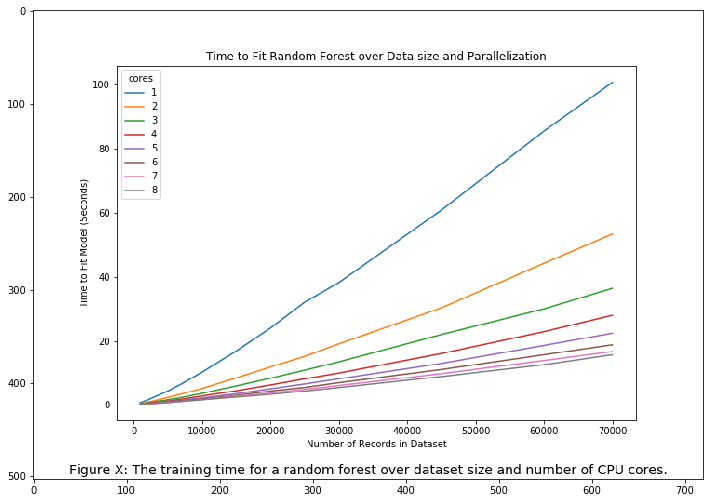

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,15))
imgplt = plt.imshow(plt.imread('./images/RF_profile.png'))

## Support Vector Machine

In [9]:
# random search without CV
svc_clf = SVC(random_state=random_state)
svc_params = {
    'C': np.geomspace(0.001, 10, num=100, dtype='float'),
    'kernel':['poly', 'rbf','sigmoid'],
    'degree':[2, 3, 4, 5],
    'gamma':['scale','auto']
}

search_iters = 30

# sample param sets
param_sets = list()
for _ in range(search_iters):
    C = random_state.choice(svc_params['C'])
    kernel = random_state.choice(svc_params['kernel'])
    if kernel == 'poly':
        degree = random_state.choice(svc_params['degree'])
    else:
        degree = 3
    if kernel != 'linear':
        gamma = random_state.choice(svc_params['gamma'])
    else:
        gamma = 'scale'
    
    param_sets.append(
        {
            'C':C,
            'kernel':kernel,
            'degree':degree,
            'gamma':gamma
            
        }
    )

# create a subset of the data for tuning
x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train,
                                                                    test_size=0.3,
                                                                    random_state=random_state)
# random downsample the training data for fit run time
sample_indicies = random_state.choice(np.arange(x_train_sub.shape[0]),
                                      size=30000, replace=False)

In [10]:
for i, p in enumerate(param_sets):
    print(i, p)

0 {'C': 2.2570197196339215, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}
1 {'C': 0.7390722033525783, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto'}
2 {'C': 0.09545484566618342, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'auto'}
3 {'C': 1.291549665014884, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'auto'}
4 {'C': 0.1668100537200059, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale'}
5 {'C': 0.019630406500402715, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'auto'}
6 {'C': 0.019630406500402715, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'auto'}
7 {'C': 0.0013219411484660286, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale'}
8 {'C': 0.05462277217684343, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale'}
9 {'C': 0.0027825594022071257, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'auto'}
10 {'C': 0.03430469286314919, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale'}
11 {'C': 2.718588242732943, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale'}
12 {'C': 0.011233240329780276, 'kernel': 'si

In [11]:
scores = list()

svc_RSCV_start_time = time.time()

# loop over the random search parameters
for i, params in enumerate(param_sets):
    loop_time_s = time.time()
    svc_clf.set_params(**params)
    svc_clf.fit(x_train_sub[sample_indicies, :],
                y_train_sub.iloc[sample_indicies])
    predictions = svc_clf.predict(x_test_sub)
    scores.append(
        log_loss(y_test_sub, predictions)
    )
    loop_time_e = time.time()
    duration = loop_time_e-loop_time_s
    # print on each iteration just to see that something is running
    print(f'{i+1}/{search_iters} Loop time:  {int(duration // 3600):02d}::{int((duration % 3600) // 60):02d}::{int((duration % 3600) % 60):02d}')

svc_RSCV_end_time = time.time()
duration = svc_RSCV_end_time-svc_RSCV_start_time
# print the total run time
print(f'\nRandomized search done. {search_iters} iterations took \
{int(duration // 3600):02d}::{int((duration % 3600)//60):02d}::{int((duration % 3600) % 60):02d}')

1/30 Loop time:  00::12::50
2/30 Loop time:  00::13::57
3/30 Loop time:  00::05::18
4/30 Loop time:  00::04::05
5/30 Loop time:  00::11::25
6/30 Loop time:  00::05::59
7/30 Loop time:  00::06::00
8/30 Loop time:  00::06::14
9/30 Loop time:  00::05::51
10/30 Loop time:  00::06::10
11/30 Loop time:  00::06::00
12/30 Loop time:  00::03::53
13/30 Loop time:  00::05::59
14/30 Loop time:  00::31::11
15/30 Loop time:  00::12::00
16/30 Loop time:  00::06::09
17/30 Loop time:  00::05::05
18/30 Loop time:  00::10::52
19/30 Loop time:  00::15::49
20/30 Loop time:  00::03::56
21/30 Loop time:  00::15::53
22/30 Loop time:  00::06::00
23/30 Loop time:  00::03::51
24/30 Loop time:  00::23::50
25/30 Loop time:  00::06::39
26/30 Loop time:  00::13::25
27/30 Loop time:  00::06::26
28/30 Loop time:  00::12::10
29/30 Loop time:  00::06::37
30/30 Loop time:  00::06::27

Randomized search done. 30 iterations took 04::40::15


In [13]:
# print the best parameters chosen by tuning
idx_best = np.argmin(scores)
svc_best_params_ = param_sets[idx_best]
print(idx_best + 1, svc_best_params_)

2 {'C': 0.7390722033525783, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto'}


In [14]:
# get CV results with best parameters
svc_clf.set_params(**svc_best_params_)
svc_cv = cross_validate(svc_clf, X_train, y_train, 
                       scoring={
                           'log_loss':log_loss_scorer,
                           'accuracy':accuracy_scorer
                       })

In [15]:
print('\nSVM 5-fold Validation Performance')
# note test_log_loss is negated due to how scorers work 
# in parameter searches in sklearn
print('Mean Log Loss\t{}'.format(np.mean(-svc_cv['test_log_loss'])))
print('Mean Accuracy\t{}'.format(np.mean(svc_cv['test_accuracy'])))


SVM 5-fold Validation Performance
Mean Log Loss	8.169185325182037
Mean Accuracy	0.7634832560872119


In [16]:
# get performance on test set
svc_clf.fit(X_train, y_train)
svc_y_test_pred = svc_clf.predict(X_test)

print('\nSVM Test Set Performance')
print('Test Log Loss\t{}'.format(log_loss(svc_y_test_pred, y_test)))
print('Test Accuracy\t{}'.format(accuracy_score(svc_y_test_pred, y_test)))


SVM Test Set Performance
Test Log Loss	8.135283183522514
Test Accuracy	0.7644595239357472


In [21]:
svc_clf = SVC(random_state=random_state)
svc_clf.set_params(**svc_best_params_)
sizes, times = list(), list()
# do some fit times for comparison with the SVM
for size in [1000, 2000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 45000, 60000, 70000]:
    sample = random_state.choice(np.arange(len(X_train)), size=size, replace=False)
    X_train_sub = X_train[sample, :]
    y_train_sub = y_train.iloc[sample]
    start_time = time.time()
    svc_clf.fit(X_train_sub, y_train_sub)
    end_time = time.time()
    duration = end_time - start_time
    print(f'SVM fit on {size} records took {duration}')
    sizes.append(size)
    times.append(duration)

SVM fit on 1000 records took 0.2931978702545166
SVM fit on 2000 records took 1.081202745437622
SVM fit on 5000 records took 7.038973808288574
SVM fit on 7000 records took 14.871310234069824
SVM fit on 10000 records took 32.43564963340759
SVM fit on 15000 records took 131.2864100933075
SVM fit on 20000 records took 265.0074608325958
SVM fit on 25000 records took 430.423392534256
SVM fit on 30000 records took 634.159389257431
SVM fit on 45000 records took 1412.8522658348083
SVM fit on 60000 records took 2459.357769727707
SVM fit on 70000 records took 3328.7520768642426


In [22]:
time_data = pd.DataFrame({
    'sizes':sizes,
    'times':times})

# save the profile for later
time_data.to_csv('./data/SVM_profiling.csv')

## Complexity Experiments

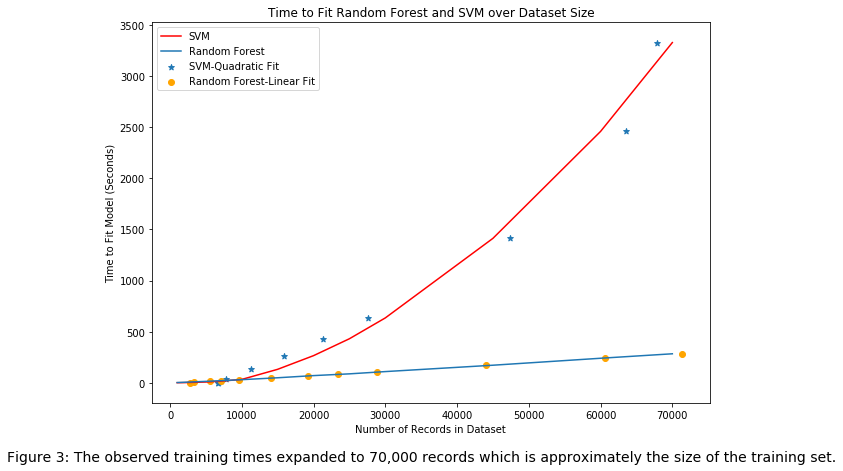

In [6]:
RF_times = pd.read_csv('./data/RF_profiling.csv').query('cores == 1')
time_data = pd.read_csv('./data/SVM_profiling.csv')

svm_coefs = poly.polyfit(time_data.times, time_data.sizes, 2)
svm_ffit = poly.polyval(time_data.times, svm_coefs)

rf_coefs = poly.polyfit(RF_times.times, RF_times.sizes, 1)
rf_ffit = poly.polyval(RF_times.times, rf_coefs)

plt.figure(figsize=(10,7))
plt.plot(time_data.sizes, time_data.times, c='r', label='SVM')
plt.scatter(svm_ffit, time_data.times, marker='*', label='SVM-Quadratic Fit')

plt.scatter(rf_ffit, RF_times.times, marker='o', c='orange', label='Random Forest-Linear Fit')
plt.plot(RF_times.sizes, RF_times.times, label = 'Random Forest')

plt.ylabel('Time to Fit Model (Seconds)')
plt.xlabel('Number of Records in Dataset')
plt.title('Time to Fit Random Forest and SVM over Dataset Size');
plt.legend();
caption = 'Figure 3: The observed training times expanded to 70,000 records which is approximately the size of the training set.'
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=14);
plt.savefig('./images/RF_SVM_Fits.png')

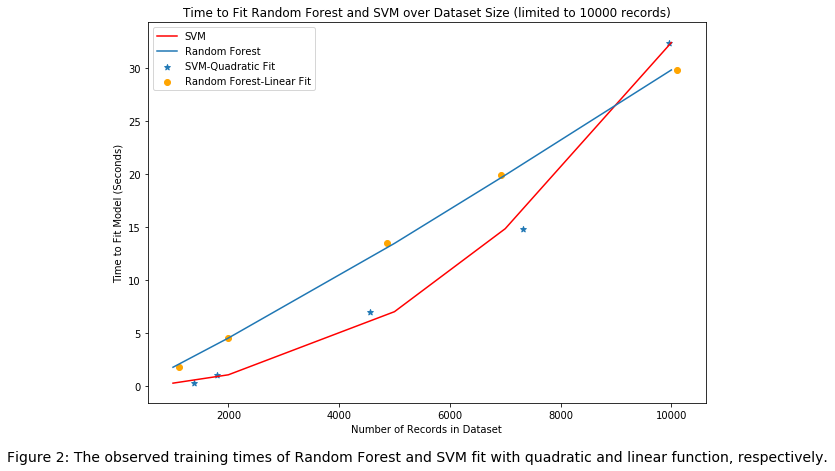

In [7]:
RF_times = pd.read_csv('./data/RF_profiling.csv').query('cores == 1').query('sizes <= 10000')
time_data = pd.read_csv('./data/SVM_profiling.csv').query('sizes <= 10000')

svm_coefs = poly.polyfit(time_data.times, time_data.sizes, 2)
svm_ffit = poly.polyval(time_data.times, svm_coefs)

rf_coefs = poly.polyfit(RF_times.times, RF_times.sizes, 1)
rf_ffit = poly.polyval(RF_times.times, rf_coefs)

plt.figure(figsize=(10,7))
plt.plot(time_data.sizes, time_data.times, c='r', label='SVM')
plt.scatter(svm_ffit, time_data.times, marker='*', label='SVM-Quadratic Fit')

plt.scatter(rf_ffit, RF_times.times, marker='o', c='orange', label='Random Forest-Linear Fit')
plt.plot(RF_times.sizes, RF_times.times, label = 'Random Forest')

plt.ylabel('Time to Fit Model (Seconds)')
plt.xlabel('Number of Records in Dataset')
plt.title('Time to Fit Random Forest and SVM over Dataset Size (limited to 10000 records)');
plt.legend();
caption = 'Figure 2: The observed training times of Random Forest and SVM fit with quadratic and linear function, respectively.'
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=14);
plt.savefig('./images/RF_SVM_Fits_Small.png')

## XGBoost

```python
## Run this on a idle ManeFrame parition 
## for parallelization

# random search 
xgb_clf = xgb.XGBClassifier(nthread=32, random_state=random_state)
xgb_params = {
    'eta': np.linspace(0.01, 1, num=100, dtype='float'),
    'gamma':np.geomspace(0.001, 10, num=1000, dtype='float'),
    'max_depth':[d for d in range(1, 11)],
    'subsample':np.linspace(0.1, 1, num=100, dtype='float'),
    'colsample_bytree':[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel':[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bynode':[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'lambda': np.geomspace(0.001, 10, num=100, dtype='float'),
    'alpha': np.geomspace(0.001, 10, num=100, dtype='float')
}

search_iters = 1000

# sample param sets
param_sets = list()
for _ in range(search_iters):
    eta = random_state.choice(xgb_params['eta']),
    gamma = random_state.choice(xgb_params['gamma']),
    max_depth = random_state.choice(xgb_params['max_depth']),
    subsample = random_state.choice(xgb_params['subsample']),
    colsample_bytree = random_state.choice(xgb_params['colsample_bytree']),
    colsample_bylevel = random_state.choice(xgb_params['colsample_bylevel']),
    colsample_bynode = random_state.choice(xgb_params['colsample_bynode']),
    lambda_ = random_state.choice(xgb_params['lambda']),
    alpha = random_state.choice(xgb_params['alpha'])
    
    param_sets.append(
        {
            'eta': eta[0],
            'gamma': gamma[0],
            'max_depth': max_depth[0],
            'subsample': subsample[0],
            'colsample_bytree': colsample_bytree[0],
            'colsample_bylevel': colsample_bylevel[0],
            'colsample_bynode': colsample_bynode[0],
            'lambda': lambda_[0],
            'alpha': alpha
        }
    )

scores_log_loss = list()
scores_accuracy = list()

xgb_RSCV_start_time = time.time()

# loop over the random search parameters
for i, params in enumerate(param_sets):
    if i % 10 == 0:
        loop_time_s = time.time()
    xgb_clf.set_params(**params)
    cv = cross_validate(xgb_clf, X_train, y_train, 
               scoring={
                   'log_loss':log_loss_scorer,
                   'accuracy':accuracy_scorer
               })
    scores_log_loss.append(
        np.mean(cv['test_log_loss'])
    )
    scores_accuracy.append(
        np.mean(cv['test_accuracy'])
    )
    
    # print on each iteration just to see that something is running
    if i % 10 == 9:
        loop_time_e = time.time()
        duration = loop_time_e-loop_time_s
        print(f'{i+1}/{search_iters} Loop time:  {int(duration // 3600):02d}::{int((duration % 3600) // 60):02d}::{int((duration % 3600) % 60):02d}')
    sys.stdout.flush()

xgb_RSCV_end_time = time.time()
duration = xgb_RSCV_end_time-xgb_RSCV_start_time
# print the total run time
print(f'\nRandomized search done. {search_iters} iterations took \
{int(duration // 3600):02d}::{int((duration % 3600)//60):02d}::{int((duration % 3600) % 60):02d}')


# print the best parameters chosen by tuning
idx_best = np.argmin(scores_log_loss)
xgb_best_params_ = param_sets[idx_best]
print('\nBest Parameters')
print(xgb_best_params_)


print('\nXGBoost 5-fold Validation Performance')
# note test_log_loss is negated due to how scorers work 
# in parameter searches in sklearn
print('Mean Log Loss\t{}'.format(-scores_log_loss[idx_best]))
print('Mean Accuracy\t{}'.format(scores_accuracy[idx_best]))


# get performance on test set
xgb_clf.set_params(**param_sets[idx_best])
xgb_clf.fit(X_train, y_train)
xgb_y_test_pred = xgb_clf.predict(X_test)

print('\nXGBoost Test Set Performance')
print('Test Log Loss\t{}'.format(log_loss(xgb_y_test_pred, y_test)))
print('Test Accuracy\t{}'.format(accuracy_score(xgb_y_test_pred, y_test)))
```

```
Randomized search done. 1000 iterations took 05::07::55

Best Parameters
{'eta': 0.53, 'gamma': 0.0010280447320933097, 'max_depth': 8, 'subsample': 0.1090909090909091, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.8, 'lambda': 0.8902150854450392, 'alpha': 0.8111308307896873}

XGBoost 5-fold Validation Performance
Mean Log Loss	11.7413698929948
Mean Accuracy	0.6600561394346889

XGBoost Test Set Performance
Test Log Loss	11.844186126112275
Test Accuracy	0.6570799978794465
```

```python
# do some fit times for comparison with XGBoost
# with the selected parameters
cpuCount = os.cpu_count()
print(f'\nThere are {cpuCount} cores available.\n')
cores, sizes, times = list(), list(), list()
for n_cores in [1, 2, 3, 4, 5, 6, 9, 12, 15, 18, 24, 32]:
    for size in [1000, 2000, 5000, 7000, 10000, 15000,
                 20000, 25000, 30000, 45000, 60000, 70000]:
        xgb_clf = xgb.XGBClassifier(random_state=random_state)
        xgb_clf.set_params(**xgb_best_params_)
        xgb_clf.set_params(**{'nthread': n_cores})
        sample = random_state.choice(np.arange(len(X_train)), size=size, replace=False)
        X_train_sub = X_train[sample, :]
        y_train_sub = y_train.iloc[sample]
        start_time = time.time()
        xgb_clf.fit(X_train_sub, y_train_sub)
        end_time = time.time()
        duration = end_time - start_time
        print(f'RF fit on {size} records with {n_cores} took {duration}')
        cores.append(n_cores)
        sizes.append(size)
        times.append(duration)

time_data = pd.DataFrame({
    'cores':cores,
    'sizes':sizes,
    'times':times})

# save the profile for later
time_data.to_csv('./data/XGB_profiling.csv')
```

```
There are 36 cores available.

RF fit on 1000 records with 1 took 0.43353962898254395
RF fit on 2000 records with 1 took 1.0441038608551025
RF fit on 5000 records with 1 took 3.2843663692474365
RF fit on 7000 records with 1 took 4.99356746673584
RF fit on 10000 records with 1 took 7.996385097503662
RF fit on 15000 records with 1 took 14.154267311096191
RF fit on 20000 records with 1 took 22.472350358963013
RF fit on 25000 records with 1 took 36.02867031097412
RF fit on 30000 records with 1 took 51.93911790847778
RF fit on 45000 records with 1 took 87.45443296432495
RF fit on 60000 records with 1 took 123.754221200943
RF fit on 70000 records with 1 took 148.07594203948975
RF fit on 1000 records with 2 took 0.24151897430419922
RF fit on 2000 records with 2 took 0.5580224990844727
RF fit on 5000 records with 2 took 1.771277666091919
RF fit on 7000 records with 2 took 2.686974048614502
RF fit on 10000 records with 2 took 4.369652509689331
RF fit on 15000 records with 2 took 7.845672845840454
RF fit on 20000 records with 2 took 12.137079000473022
RF fit on 25000 records with 2 took 20.19027090072632
RF fit on 30000 records with 2 took 28.072140216827393
RF fit on 45000 records with 2 took 51.76918625831604
RF fit on 60000 records with 2 took 72.68717360496521
RF fit on 70000 records with 2 took 86.9029586315155
RF fit on 1000 records with 3 took 0.19548320770263672
RF fit on 2000 records with 3 took 0.4065206050872803
RF fit on 5000 records with 3 took 1.211782455444336
RF fit on 7000 records with 3 took 1.852858066558838
RF fit on 10000 records with 3 took 2.9375433921813965
RF fit on 15000 records with 3 took 5.249641180038452
RF fit on 20000 records with 3 took 8.049489736557007
RF fit on 25000 records with 3 took 13.586398601531982
RF fit on 30000 records with 3 took 19.49942421913147
RF fit on 45000 records with 3 took 34.44937252998352
RF fit on 60000 records with 3 took 49.592509031295776
RF fit on 70000 records with 3 took 59.01192569732666
RF fit on 1000 records with 4 took 0.13785362243652344
RF fit on 2000 records with 4 took 0.3042781352996826
RF fit on 5000 records with 4 took 0.9117114543914795
RF fit on 7000 records with 4 took 1.4217345714569092
RF fit on 10000 records with 4 took 2.2908220291137695
RF fit on 15000 records with 4 took 3.937563896179199
RF fit on 20000 records with 4 took 5.938636064529419
RF fit on 25000 records with 4 took 10.04543685913086
RF fit on 30000 records with 4 took 14.220710754394531
RF fit on 45000 records with 4 took 25.494035720825195
RF fit on 60000 records with 4 took 36.922921657562256
RF fit on 70000 records with 4 took 44.14434266090393
RF fit on 1000 records with 5 took 0.12350201606750488
RF fit on 2000 records with 5 took 0.2711911201477051
RF fit on 5000 records with 5 took 0.8475115299224854
RF fit on 7000 records with 5 took 1.187089443206787
RF fit on 10000 records with 5 took 1.956359624862671
RF fit on 15000 records with 5 took 3.421715021133423
RF fit on 20000 records with 5 took 4.930887460708618
RF fit on 25000 records with 5 took 8.532436609268188
RF fit on 30000 records with 5 took 11.936099290847778
RF fit on 45000 records with 5 took 20.938836097717285
RF fit on 60000 records with 5 took 30.18942093849182
RF fit on 70000 records with 5 took 36.06401324272156
RF fit on 1000 records with 6 took 0.11268925666809082
RF fit on 2000 records with 6 took 0.23059415817260742
RF fit on 5000 records with 6 took 0.7032561302185059
RF fit on 7000 records with 6 took 1.047940731048584
RF fit on 10000 records with 6 took 1.6114656925201416
RF fit on 15000 records with 6 took 2.8681349754333496
RF fit on 20000 records with 6 took 4.311212062835693
RF fit on 25000 records with 6 took 7.1080873012542725
RF fit on 30000 records with 6 took 10.087202310562134
RF fit on 45000 records with 6 took 17.731508493423462
RF fit on 60000 records with 6 took 25.384495973587036
RF fit on 70000 records with 6 took 30.435585737228394
RF fit on 1000 records with 9 took 0.10119390487670898
RF fit on 2000 records with 9 took 0.20284819602966309
RF fit on 5000 records with 9 took 0.5426473617553711
RF fit on 7000 records with 9 took 0.7777009010314941
RF fit on 10000 records with 9 took 1.1906864643096924
RF fit on 15000 records with 9 took 2.1233763694763184
RF fit on 20000 records with 9 took 3.2592670917510986
RF fit on 25000 records with 9 took 5.154683589935303
RF fit on 30000 records with 9 took 7.063689470291138
RF fit on 45000 records with 9 took 12.309399366378784
RF fit on 60000 records with 9 took 17.75273847579956
RF fit on 70000 records with 9 took 21.126389503479004
RF fit on 1000 records with 12 took 0.09235334396362305
RF fit on 2000 records with 12 took 0.1755053997039795
RF fit on 5000 records with 12 took 0.46157217025756836
RF fit on 7000 records with 12 took 0.6635110378265381
RF fit on 10000 records with 12 took 1.032893180847168
RF fit on 15000 records with 12 took 1.7248103618621826
RF fit on 20000 records with 12 took 2.6435389518737793
RF fit on 25000 records with 12 took 4.097490549087524
RF fit on 30000 records with 12 took 5.694245100021362
RF fit on 45000 records with 12 took 9.591136932373047
RF fit on 60000 records with 12 took 13.73383355140686
RF fit on 70000 records with 12 took 16.439476490020752
RF fit on 1000 records with 15 took 0.08212065696716309
RF fit on 2000 records with 15 took 0.16945791244506836
RF fit on 5000 records with 15 took 0.39053797721862793
RF fit on 7000 records with 15 took 0.575894832611084
RF fit on 10000 records with 15 took 0.8972969055175781
RF fit on 15000 records with 15 took 1.5355112552642822
RF fit on 20000 records with 15 took 2.321108341217041
RF fit on 25000 records with 15 took 3.548360824584961
RF fit on 30000 records with 15 took 4.819944381713867
RF fit on 45000 records with 15 took 8.108754634857178
RF fit on 60000 records with 15 took 11.536372900009155
RF fit on 70000 records with 15 took 13.841092824935913
RF fit on 1000 records with 18 took 0.08291101455688477
RF fit on 2000 records with 18 took 0.16508054733276367
RF fit on 5000 records with 18 took 0.3615872859954834
RF fit on 7000 records with 18 took 0.5195703506469727
RF fit on 10000 records with 18 took 0.8130671977996826
RF fit on 15000 records with 18 took 1.3944268226623535
RF fit on 20000 records with 18 took 1.9804091453552246
RF fit on 25000 records with 18 took 3.008817195892334
RF fit on 30000 records with 18 took 4.149754762649536
RF fit on 45000 records with 18 took 6.923675060272217
RF fit on 60000 records with 18 took 9.939695358276367
RF fit on 70000 records with 18 took 11.778961420059204
RF fit on 1000 records with 24 took 0.11001944541931152
RF fit on 2000 records with 24 took 0.14208483695983887
RF fit on 5000 records with 24 took 0.3109102249145508
RF fit on 7000 records with 24 took 0.4214596748352051
RF fit on 10000 records with 24 took 0.6577553749084473
RF fit on 15000 records with 24 took 1.1061415672302246
RF fit on 20000 records with 24 took 1.669098138809204
RF fit on 25000 records with 24 took 2.4491143226623535
RF fit on 30000 records with 24 took 3.3352909088134766
RF fit on 45000 records with 24 took 5.368535995483398
RF fit on 60000 records with 24 took 7.631534099578857
RF fit on 70000 records with 24 took 9.121984004974365
RF fit on 1000 records with 32 took 0.1828022003173828
RF fit on 2000 records with 32 took 0.2082211971282959
RF fit on 5000 records with 32 took 0.2754819393157959
RF fit on 7000 records with 32 took 0.3775520324707031
RF fit on 10000 records with 32 took 0.5676159858703613
RF fit on 15000 records with 32 took 0.9673726558685303
RF fit on 20000 records with 32 took 1.4147193431854248
RF fit on 25000 records with 32 took 2.0175063610076904
RF fit on 30000 records with 32 took 2.7227988243103027
RF fit on 45000 records with 32 took 4.338773727416992
RF fit on 60000 records with 32 took 6.110126733779907
RF fit on 70000 records with 32 took 7.252415895462036
```

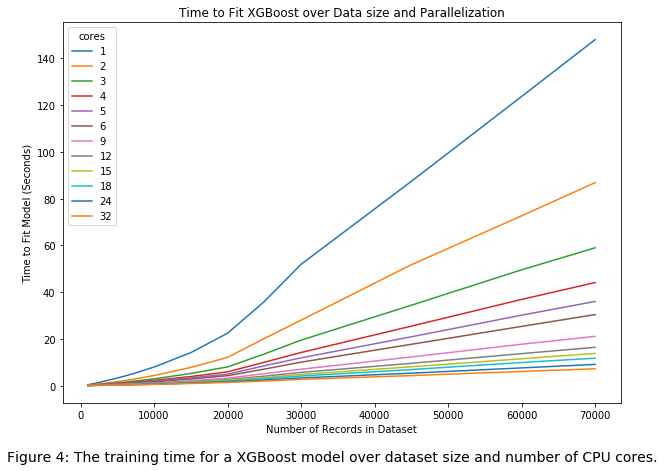

In [8]:
time_data = pd.read_csv('./data/XGB_profiling.csv')
df = time_data.pivot(index='sizes', columns='cores', values='times')

df.plot(figsize = (10,7))
plt.ylabel('Time to Fit Model (Seconds)')
plt.xlabel('Number of Records in Dataset')
plt.title('Time to Fit XGBoost over Data size and Parallelization');
caption = 'Figure 4: The training time for a XGBoost model over dataset size and number of CPU cores.'
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=14);
plt.savefig('./images/XGB_profile.png')